In [ ]:
# .nii 파일 shape, metadata 확인

import nibabel as nib
import numpy as np

file_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/raw_prep_vol/sub-01/brainmask.nii.gz'
img = nib.load(file_path)
data = img.get_fdata()

print(data.shape)

header = img.header
print(header)

(81, 104, 83)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  81 104  83   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.  1.8 1.8 1.8 1.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 1
glmin           : 0
descrip         : b''
aux_file        : b'none'
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [  1.8   0. 

In [1]:
#.npy 파일 shape 확인

import numpy as np

file_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/nsdgeneral_test.npy'
data = np.load(file_path)
print(f"배열의 shape: {data.shape}")
print(data)


배열의 shape: (982, 15724)
[[ 0.4685  -0.3406  -0.107   ... -0.1604   0.5244   0.1628 ]
 [-0.4307  -0.1251  -0.1589  ...  0.8584  -0.05576 -0.3054 ]
 [ 0.6665   0.6816   0.2654  ...  0.561    0.675    0.4456 ]
 ...
 [-0.2766  -0.08405  0.892   ... -0.2181  -0.896   -0.644  ]
 [-0.2634  -1.029    0.0542  ...  0.1042  -0.588   -0.3652 ]
 [-0.8687  -1.439   -0.6455  ... -0.5825  -0.8076  -0.5776 ]]


In [ ]:
import nibabel as nib
import numpy as np

# 파일 경로
beta_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/normalize/sub-01/betas_session03.nii.gz'

# 데이터 로드
beta_img = nib.load(beta_path)
beta_data = beta_img.get_fdata()  # shape: (x, y, z, t)

# t=1 (두 번째 timepoint)의 3D 볼륨
volume_t1 = beta_data[..., 1]  # shape: (x, y, z)

# 값이 0이 아닌 (x, y, z) 좌표의 개수 세기
non_zero_voxel_count = np.count_nonzero(volume_t1)

print(f"✅ t=1에서 intensity가 0이 아닌 복셀 수: {non_zero_voxel_count}")


In [ ]:
# beta파일 bids 형식으로 만들기
import os
import re
import shutil

# 원본 루트 폴더
root_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi"
# 새로운 저장 루트 (BIDS 형식으로 저장할 곳)
output_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi2"

os.makedirs(output_dir, exist_ok=True)

for subject_folder in os.listdir(root_dir):
    subject_path = os.path.join(root_dir, subject_folder)
    if os.path.isdir(subject_path) and subject_folder.startswith("sub-"):
        subject_id = subject_folder.split("-")[1]

        for filename in os.listdir(subject_path):
            if filename.startswith("betas_session") and filename.endswith(".nii.gz"):
                session_match = re.search(r'session(\d+)', filename)
                if session_match:
                    session_num = session_match.group(1).zfill(2)
                    desc = "betaroi"  # 파일 이름
                    new_filename = f"sub-{subject_id}_ses-{session_num}_desc-{desc}.nii.gz"

                    bids_sub_dir = os.path.join(output_dir, f"sub-{subject_id}", f"ses-{session_num}", "func")
                    os.makedirs(bids_sub_dir, exist_ok=True)

                    src_file = os.path.join(subject_path, filename)
                    dst_file = os.path.join(bids_sub_dir, new_filename)
                    shutil.copy2(src_file, dst_file)

In [ ]:
import nibabel as nib
import numpy as np

# z-score 정규화된 fMRI 파일
zscore_file = '/nas/research/03-Neural_decoding/3-bids/derivatives/new_b4_roi_zscore/sub-01/ses-01/func/sub-01_ses-01_desc-betaroizscore.nii.gz'
# 마스크 파일
mask_file = '/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_zscore/sub-01/sub-01_nsdgeneral.nii.gz'

# 데이터 로딩
zdata = nib.load(zscore_file).get_fdata()  # shape: (X, Y, Z, T)
mask = nib.load(mask_file).get_fdata() > 0  # shape: (X, Y, Z), boolean

# 시간축 기준 voxel-wise 평균/표준편차 계산 → shape: (X, Y, Z)
voxel_means = np.mean(zdata, axis=-1)
voxel_stds = np.std(zdata, axis=-1)

# 마스크 영역만 골라서 평균 계산
mean_of_means = np.mean(voxel_means[mask])
mean_of_stds = np.mean(voxel_stds[mask])

print(f"[Voxel-wise] 마스크 영역 평균들의 평균: {mean_of_means:.4f}")
print(f"[Voxel-wise] 마스크 영역 표준편차들의 평균: {mean_of_stds:.4f}")




[Voxel-wise] 마스크 영역 평균들의 평균: 0.0000
[Voxel-wise] 마스크 영역 표준편차들의 평균: 1.0000


In [ ]:
#h5py 파일 압축 풀기

import h5py
import os
import numpy as np

def hdf5_to_folder(hdf5_path, output_dir):
    def recursively_save(h5_obj, current_path):
        for key in h5_obj:
            item = h5_obj[key]
            item_path = os.path.join(current_path, key)
            if isinstance(item, h5py.Dataset):
                # npy로 저장
                np.save(item_path + '.npy', item[()])
            elif isinstance(item, h5py.Group):
                os.makedirs(item_path, exist_ok=True)
                recursively_save(item, item_path)

    with h5py.File(hdf5_path, 'r') as f:
        os.makedirs(output_dir, exist_ok=True)
        recursively_save(f, output_dir)

# 사용 예
hdf5_to_folder(
    hdf5_path='/nas/research/03-Neural_decoding/3-bids/test_files/subj01_nsdgeneral.hdf5',
    output_dir='/nas/research/03-Neural_decoding/3-bids/test_files'
)

In [ ]:
import numpy as np

voxels = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.coco73k.npy')
print(voxels)


#images = np.load('/nas/research/03-Neural_decoding/3-bids/subj01_nsdgeneral_extracted/images.npy')
#print(images.shape)

[2516]


Shape: (15724,)
Min: -3.752
Max: 3.53
Mean: -0.2416
Std: 0.8574
Median: -0.254


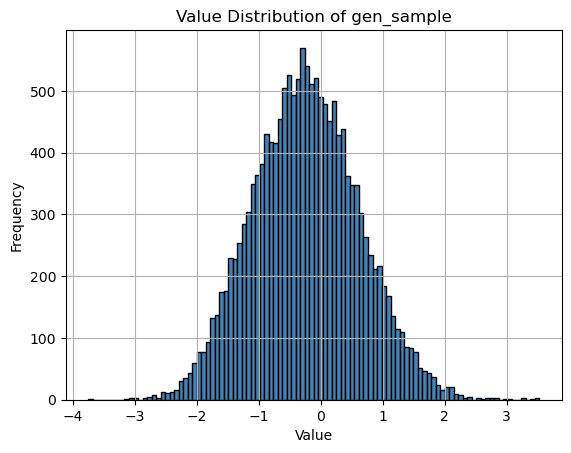

In [ ]:
import numpy as np

gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.nsdgeneral.npy')[1]
# gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-21/func/sub-01_ses-21_desc-betaroizscore.npy')[329]

print("Shape:", gen_sample.shape)
print("Min:", np.min(gen_sample))
print("Max:", np.max(gen_sample))
print("Mean:", np.mean(gen_sample))
print("Std:", np.std(gen_sample))
print("Median:", np.median(gen_sample))
import matplotlib.pyplot as plt

plt.hist(gen_sample.flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Value Distribution of gen_sample")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [ ]:
import numpy as np

# pixcorr 함수 정의
def pixcorr(a, b):
    return np.corrcoef(a.flatten(), b.flatten())[0, 1]

# --- 1. fMRI 응답 벡터 불러오기 ---
# (a) ses-36, TR 47
data1 = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-21/func/sub-01_ses-21_desc-betaroizscore.npy')
print(data1.shape)
vec1 = data1[329]  # shape: (15724,)

# (b) ses-37, TR 390
data2 = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-24/func/sub-01_ses-24_desc-betaroizscore.npy')
print(data2.shape)
vec2 = data2[186]
vec3 = data2[329]

# --- 2. 생성 이미지의 feature 벡터 불러오기 ---
gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.nsdgeneral.npy')
print(gen_sample.shape)
# gen_sample shape = (3, 15724) 라면, 각 행이 하나의 샘플 벡터
gen1, gen2, gen3 = gen_sample[0], gen_sample[1], gen_sample[2]

# --- 3. pixcorr 계산 ---
print("pixcorr(vec1, gen1):", pixcorr(vec1, gen1))
print("pixcorr(vec2, gen2):", pixcorr(vec2, gen2))
print("pixcorr(vec3, gen3):", pixcorr(vec3, gen3))


(750, 15724)
(750, 15724)
(3, 15724)
pixcorr(vec1, gen1): -0.24386000123148174
pixcorr(vec2, gen2): -0.2520202925822968
pixcorr(vec3, gen3): -0.2735316386893801


In [ ]:
import nibabel as nib
import os

# 원본 파일 경로
mgz_file = '/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest_fmriprep/sourcedata/freesurfer/sub-01/mri/T1.mgz'

# 출력 파일 경로 (같은 디렉토리에 .nii.gz로 저장)
nii_gz_file = os.path.splitext(mgz_file)[0] + '.nii.gz'

# mgz 파일 로드
img = nib.load(mgz_file)

# nii.gz로 저장
nib.save(img, nii_gz_file)

print(f"변환 완료: {nii_gz_file}")


변환 완료: /nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest_fmriprep/sourcedata/freesurfer/sub-01/mri/T1.nii.gz


In [ ]:
import os

root_dir = "/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01"

count = 0
for dirpath, dirnames, filenames in os.walk(root_dir):
    for fname in filenames:
        # 파일명에 'task-rest'가 포함되고 '.nii.gz'로 끝나는지 검사
        if "task-rest" in fname and fname.endswith(".nii.gz"):
            full_path = os.path.join(dirpath, fname)
            print(full_path)
            count += 1

print(f"\n총 파일 개수: {count}")


/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-21/func/sub-01_ses-21_task-rest_run-02_bold.nii.gz
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-21/func/sub-01_ses-21_task-rest_run-01_bold.nii.gz
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-22/func/sub-01_ses-22_task-rest_run-01_bold.nii.gz
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-22/func/sub-01_ses-22_task-rest_run-02_bold.nii.gz
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-23/func/sub-01_ses-23_task-rest_run-02_bold.nii.gz
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-23/func/sub-01_ses-23_task-rest_run-01_bold.nii.gz
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-24/func/sub-01_ses-24_task-rest_run-02_bold.nii.gz
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-24/func/sub-01_ses-24_task-rest_run-01_bold.nii.gz
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-25/func/sub-01_ses-25_task-rest_run-02_bold.nii.gz
/

In [ ]:
import os
import shutil
from glob import glob

# 원본과 대상 루트 경로
raw_root  = "/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01"
dest_root = "/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01"

for ses in range(21, 39):  # 21 ~ 38
    ses_folder = f"ses-{ses:02d}"
    src_func = os.path.join(raw_root,  ses_folder, "func")
    dst_func = os.path.join(dest_root, ses_folder, "func")
    
    # 복사할 파일 패턴: run-01 과 run-02
    for run in ("01", "02"):
        pattern = os.path.join(
            src_func,
            f"sub-01_{ses_folder}_task-rest_run-{run}_bold.json"
        )
        for src_path in glob(pattern):
            # 대상 경로에 파일명 그대로 복사
            dst_path = os.path.join(dst_func, os.path.basename(src_path))
            shutil.copy2(src_path, dst_path)
            print(f"Copied: {src_path} → {dst_path}")



Copied: /nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-21/func/sub-01_ses-21_task-rest_run-01_bold.json → /nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/ses-21/func/sub-01_ses-21_task-rest_run-01_bold.json
Copied: /nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-21/func/sub-01_ses-21_task-rest_run-02_bold.json → /nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/ses-21/func/sub-01_ses-21_task-rest_run-02_bold.json
Copied: /nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-22/func/sub-01_ses-22_task-rest_run-01_bold.json → /nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/ses-22/func/sub-01_ses-22_task-rest_run-01_bold.json
Copied: /nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-22/func/sub-01_ses-22_task-rest_run-02_bold.json → /nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/ses-22/func/sub-01_ses-22_task-rest_run-02_bold.json
Copied: /nas/research/03-Neural_decoding

In [ ]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm

# 입력 및 출력 경로 설정
input_base = "/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest_fmriprep/sub-01"
output_base = "/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01"

sessions = [f"ses-{i:02d}" for i in range(21, 39)]
runs = [f"run-{i:02d}" for i in range(1, 3)]

for ses in tqdm(sessions, desc="Processing sessions"):
    for run in runs:
        func_input_dir = os.path.join(input_base, ses, "func")
        bold_path = os.path.join(func_input_dir, f"sub-01_{ses}_task-rest_{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
        mask_path = os.path.join(func_input_dir, f"sub-01_{ses}_task-rest_{run}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")

        if not os.path.exists(bold_path) or not os.path.exists(mask_path):
            print(f"Missing files for {ses} {run}")
            continue

        bold_img = nib.load(bold_path)
        mask_img = nib.load(mask_path)

        bold_data = bold_img.get_fdata()         # (X, Y, Z, T)
        mask_data = mask_img.get_fdata()         # (X, Y, Z), 값은 0 또는 1
        affine = bold_img.affine
        header = bold_img.header

        # 마스크를 4D로 확장하여 곱셈 (broadcasting)
        masked_bold = bold_data * mask_data[..., np.newaxis]  # (X, Y, Z, T)

        # 출력 디렉토리 생성
        func_output_dir = os.path.join(output_base, ses, "func")
        os.makedirs(func_output_dir, exist_ok=True)

        # 저장 경로 및 파일 저장
        output_path = os.path.join(func_output_dir, f"sub-01_{ses}_task-rest_{run}_space-MNI152NLin2009cAsym_desc-be_bold.nii.gz")
        masked_img = nib.Nifti1Image(masked_bold, affine=affine, header=header)
        nib.save(masked_img, output_path)


Processing sessions: 100%|██████████| 18/18 [11:28<00:00, 38.23s/it]


In [ ]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm

# 경로 설정
bold_base = "/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01"
dk_path = os.path.join(bold_base, "dk_mask_MNI.nii.gz")

# 사용할 DK label 정의 (시각 처리 관련 20개 ROI)
target_labels = np.array([
    1005, 1007, 1008, 1009, 1011, 1013, 1015, 1016, 1021, 1029,
    2005, 2007, 2008, 2009, 2011, 2013, 2015, 2016, 2021, 2029
])

# DK atlas 로드
dk_img = nib.load(dk_path)
dk_data = dk_img.get_fdata()

sessions = [f"ses-{i:02d}" for i in range(21, 39)]
runs = [f"run-{i:02d}" for i in range(1, 3)]

for ses in tqdm(sessions, desc="Sessions"):
    for run in runs:
        func_dir = os.path.join(bold_base, ses, "func")
        bold_file = os.path.join(func_dir, f"sub-01_{ses}_task-rest_{run}_space-MNI152NLin2009cAsym_desc-be_bold.nii.gz")

        if not os.path.exists(bold_file):
            print(f"File missing: {bold_file}")
            continue

        # fMRI 로드
        bold_img = nib.load(bold_file)
        bold_data = bold_img.get_fdata()  # shape: (X, Y, Z, T)
        T = bold_data.shape[-1]

        # 각 ROI별 평균 시계열 계산
        roi_ts_list = []
        for label in target_labels:
            mask = (dk_data == label)
            roi_voxels = bold_data[mask]  # shape: (n_voxels, T)

            if roi_voxels.size == 0:
                print(f"Warning: label {label} has no voxels in {bold_file}")
                roi_mean = np.zeros(T)
            else:
                roi_mean = np.mean(roi_voxels, axis=0)  # shape: (T,)

            roi_ts_list.append(roi_mean)

        roi_ts = np.stack(roi_ts_list, axis=1)  # shape: (T, 20)

        # Z-score normalization (time series 기준)
        roi_z = (roi_ts - np.mean(roi_ts, axis=0)) / np.std(roi_ts, axis=0)

        # FC matrix 계산
        fc_matrix = np.corrcoef(roi_z.T)  # shape: (20, 20)

        # 저장
        out_prefix = f"sub-01_{ses}_{run}"
        np.save(os.path.join(func_dir, f"{out_prefix}_roi_timeseries_vis20.npy"), roi_ts)
        np.save(os.path.join(func_dir, f"{out_prefix}_fc_matrix_vis20.npy"), fc_matrix)



Sessions: 100%|██████████| 18/18 [01:31<00:00,  5.07s/it]


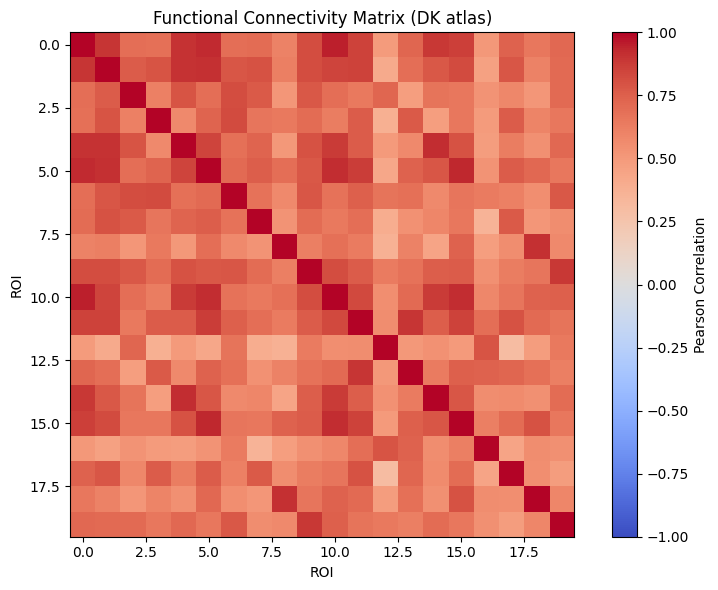

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 저장된 FC 행렬 경로 (예시: ses-21, run-01)
fc_path = "/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/ses-21/func/sub-01_ses-21_run-01_fc_matrix_vis20.npy"

# FC 행렬 로드
fc_matrix = np.load(fc_path)

# 시각화
plt.figure(figsize=(8, 6))
plt.imshow(fc_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.title('Functional Connectivity Matrix (DK atlas)')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.tight_layout()
plt.show()


In [ ]:
import nibabel as nib
import numpy as np

dk = nib.load("/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/DK-atlas-fmri.nii.gz")
t1 = nib.load("/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/anat/sub-01_ses-01_T1w.nii.gz")

print("Affine diff:\n", dk.affine - t1.affine)
print("Max diff:", np.max(np.abs(dk.affine - t1.affine)))



Affine diff:
 [[ 1.00066108e+00  1.63368136e-02  2.79503167e-02  3.38277435e+00]
 [-1.92222763e-02  1.00475204e+00 -8.49191621e-02  3.21049652e+01]
 [-2.60499660e-02  8.55211839e-02  1.00501090e+00  2.98438950e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Max diff: 32.10496520996094


In [ ]:
import os
import numpy as np

# 세션 및 런 리스트 정의
sessions = [f"ses-{i:02d}" for i in range(21, 39)]
runs = [f"run-{i:02d}" for i in range(1, 3)]

# 경로 베이스
base_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01"

fc_matrices = []

for ses in sessions:
    for run in runs:
        fc_path = os.path.join(base_dir, ses, "func", f"sub-01_{ses}_{run}_fc_matrix_vis20.npy")
        if os.path.exists(fc_path):
            fc = np.load(fc_path)
            if fc.shape == (20, 20):
                fc_matrices.append(fc)
            else:
                print(f"Skipping {fc_path} due to unexpected shape: {fc.shape}")
        else:
            print(f"Missing: {fc_path}")

# 평균 계산
if fc_matrices:
    fc_mean = np.mean(fc_matrices, axis=0)
    out_path = os.path.join(base_dir, "fc_matrix_vis20_mean.npy")
    np.save(out_path, fc_mean)
    print(f"Saved average FC matrix to: {out_path}")
else:
    print("No valid FC matrices found.")



Saved average FC matrix to: /nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/fc_matrix_vis20_mean.npy


In [34]:
import os
import numpy as np
import nibabel as nib

# 경로 설정
bold_base = "/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01"
dk_path = os.path.join(bold_base, "dk_mask_MNI.nii.gz")

# DK atlas 로드
dk_img = nib.load(dk_path)
dk_data = dk_img.get_fdata()
all_labels = np.unique(dk_data)
all_labels = all_labels[all_labels != 0]  # background 제외

# 처리할 세션/런
session = "ses-21"
runs = ["run-01", "run-02"]

for run in runs:
    func_dir = os.path.join(bold_base, session, "func")
    bold_file = os.path.join(
        func_dir, f"sub-01_{session}_task-rest_{run}_space-MNI152NLin2009cAsym_desc-be_bold.nii.gz"
    )

    if not os.path.exists(bold_file):
        print(f"File missing: {bold_file}")
        continue

    # fMRI 로드
    bold_img = nib.load(bold_file)
    bold_data = bold_img.get_fdata()  # (X, Y, Z, T)
    T = bold_data.shape[-1]

    roi_ts_list = []
    for label in all_labels:
        mask = (dk_data == label)
        roi_voxels = bold_data[mask]  # (n_voxels, T)

        if roi_voxels.size == 0:
            print(f"Warning: label {label} has no voxels in {bold_file}")
            roi_mean = np.zeros(T)
        else:
            roi_mean = np.mean(roi_voxels, axis=0)

        roi_ts_list.append(roi_mean)

    roi_ts = np.stack(roi_ts_list, axis=1)  # (T, N_ROI)

    # Z-score 정규화
    roi_z = (roi_ts - np.mean(roi_ts, axis=0)) / np.std(roi_ts, axis=0)

    # FC matrix 계산
    fc_matrix = np.corrcoef(roi_z.T)  # (N_ROI, N_ROI)

    # 저장
    out_prefix = f"sub-01_{session}_{run}"
    np.save(os.path.join(func_dir, f"{out_prefix}_roi_timeseries_all.npy"), roi_ts)
    np.save(os.path.join(func_dir, f"{out_prefix}_fc_matrix_all.npy"), fc_matrix)

    print(f"{run} 저장 완료: {fc_matrix.shape}")


run-01 저장 완료: (103, 103)
run-02 저장 완료: (103, 103)


/tmp/ipykernel_2521489/853608085.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('PuBu')


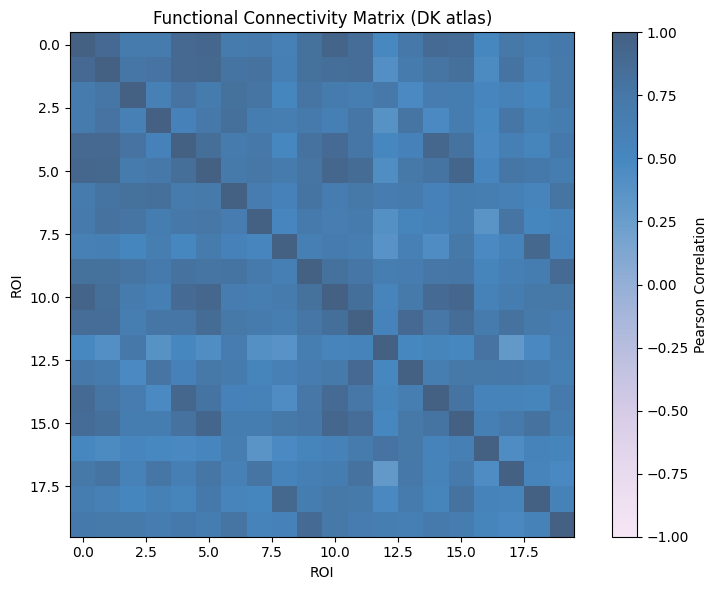

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

base_cmap = plt.cm.get_cmap('PuBu')
colors = base_cmap(np.linspace(0, 1, 256))
bg_color1 = np.array([0xE1,0xBE,0xE7]) / 255
blend_factor = 0.3
white = np.ones(3)
colors[:, :3] = colors[:, :3] + (bg_color1 - colors[:, :3]) * blend_factor
light_PuBu = mpl.colors.LinearSegmentedColormap.from_list('LightPuBu', colors)

# 저장된 FC 행렬 경로 (예시: ses-21, run-01)
fc_path = "/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/ses-21/func/sub-01_ses-21_run-01_fc_matrix_vis20.npy"

# FC 행렬 로드
fc_matrix = np.load(fc_path)

# 시각화
plt.figure(figsize=(8, 6))
plt.imshow(fc_matrix, cmap=light_PuBu, vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.title('Functional Connectivity Matrix (DK atlas)')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.tight_layout()
plt.show()


In [47]:
import numpy as np
import os

# 파일 경로
fc_path = "/nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/ses-21/func/sub-01_ses-21_run-01_fc_matrix_all.npy"

# FC matrix 로드
fc_matrix = np.load(fc_path)

# r2z 변환 함수 적용
# 1 또는 -1에 너무 가까운 값은 안정적으로 처리하기 위해 epsilon으로 클리핑
eps = 1e-7
z_mat = np.arctanh(fc_matrix)
z_mat[~np.isfinite(z_mat)] = 0

# 저장 경로
out_path = fc_path.replace(".npy", "_r2z.npy")
np.save(out_path, z_mat)

print(f"r-to-z 변환 완료: {out_path}")


r-to-z 변환 완료: /nas/research/03-Neural_decoding/3-bids/derivatives/raw_rest/sub-01/ses-21/func/sub-01_ses-21_run-01_fc_matrix_all_r2z.npy


/tmp/ipykernel_2355812/2990138919.py:13: RuntimeWarning: divide by zero encountered in arctanh
  z_mat = np.arctanh(fc_matrix)
